In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import warnings
import warnings

from open_data  import matlab_file
from structure_data import  structure
from compute.classif import classify

sns.set_style("whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
lab_desktop = True

measure = 'Rate_convol'
classif = 'HistGrad'

if lab_desktop : 
    session = 't150204001'
    data_path = f'/home/INT/mifsud.l/Bureau/data/Tommy/{session}/modified_data/' #f'~/Bureau/data/Tommy/{session}/modified_data'
    info_path = '/home/INT/mifsud.l/Bureau/Lists&Documentation/TomyCerebusSpikes_Updated_June2023.xlsx'
    result_path = '~/Bureau/results'

else : 
    session = 't150204001'
    data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
    info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'

print(f'session : {session}')
    
acc_df_rate_convol = pd.read_csv(f'{result_path}/{session}_HistGrad_Rate_convol.csv')
acc_df_sync = pd.read_csv(f'{result_path}/{session}_HistGrad_synch.csv')
acc_df_id = pd.read_csv(f'{result_path}/{session}_HistGrad_ID.csv')

session : t150204001


In [14]:
acc_df_rate_convol.head()

,Unnamed: 0,split,data_type,time,target_type,accuracy
0,0,0,test,0,trial_type,0.694444
1,1,0,shuff,0,trial_type,0.388889
2,2,0,test,100,trial_type,0.750000
3,3,0,shuff,100,trial_type,0.333333
4,4,0,test,200,trial_type,0.666667


In [15]:
acc_df_sync.head()

,Unnamed: 0,split,data_type,time,target_type,accuracy
0,0,0,test,0,trial_type,0.777778
1,1,0,shuff,0,trial_type,0.388889
2,2,0,test,100,trial_type,0.805556
3,3,0,shuff,100,trial_type,0.444444
4,4,0,test,200,trial_type,0.750000


In [16]:
acc_df_id.head()

,Unnamed: 0,split,data_type,time,target_type,accuracy
0,0,0,test,0,trial_type,0.472222
1,1,0,shuff,0,trial_type,0.333333
2,2,0,test,100,trial_type,0.555556
3,3,0,shuff,100,trial_type,0.388889
4,4,0,test,200,trial_type,0.694444


In [17]:
data_list = [acc_df_rate_convol, acc_df_sync, acc_df_id]
measures_list = ['Rate_convol', 'Synchrony', 'ISI_Distance']
    
for data in data_list:
    data.drop(columns='Unnamed: 0', inplace=True)

In [18]:
acc_df_rate_convol

,split,data_type,time,target_type,accuracy
0,0,test,0,trial_type,0.694444
1,0,shuff,0,trial_type,0.388889
2,0,test,100,trial_type,0.750000
3,0,shuff,100,trial_type,0.333333
4,0,test,200,trial_type,0.666667
...,...,...,...,...,...
785,4,shuff,7600,trial_type,0.416667
786,4,test,7700,trial_type,0.416667
787,4,shuff,7700,trial_type,0.416667
788,4,test,7800,trial_type,0.416667


In [19]:
# import data from matlab file
data, load_info = matlab_file.open(data_path)
# clean data 
df = matlab_file.clean(info_path)
# get sessions and units info 
info_units,  info_session = structure.info(load_info, df, session)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(structure.elitrials)
print(info_session.shape)

# get unit's index without eli trials 
completeUnit = structure.CompleteTasktime(info_session, load_info, session)


43 files loaded
(45, 8)
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 2


In [20]:
# extract data from the matlab file
task_data = matlab_file.extract_task_data(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], event_keys_OFF=[])
event_labels = matlab_file.get_event_labels(task_data)
event_times = matlab_file.get_event_times(task_data, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = structure.events_by_trial(event_times, event_labels)

# Data formating

In [21]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()
event_vector = df_task_ts.loc[0].values - df_task_ts.loc[0].values[0]
event_vector

array([   0, 1077, 1395, 2396, 2703, 3704, 4025, 5025, 5333, 6310, 6923])

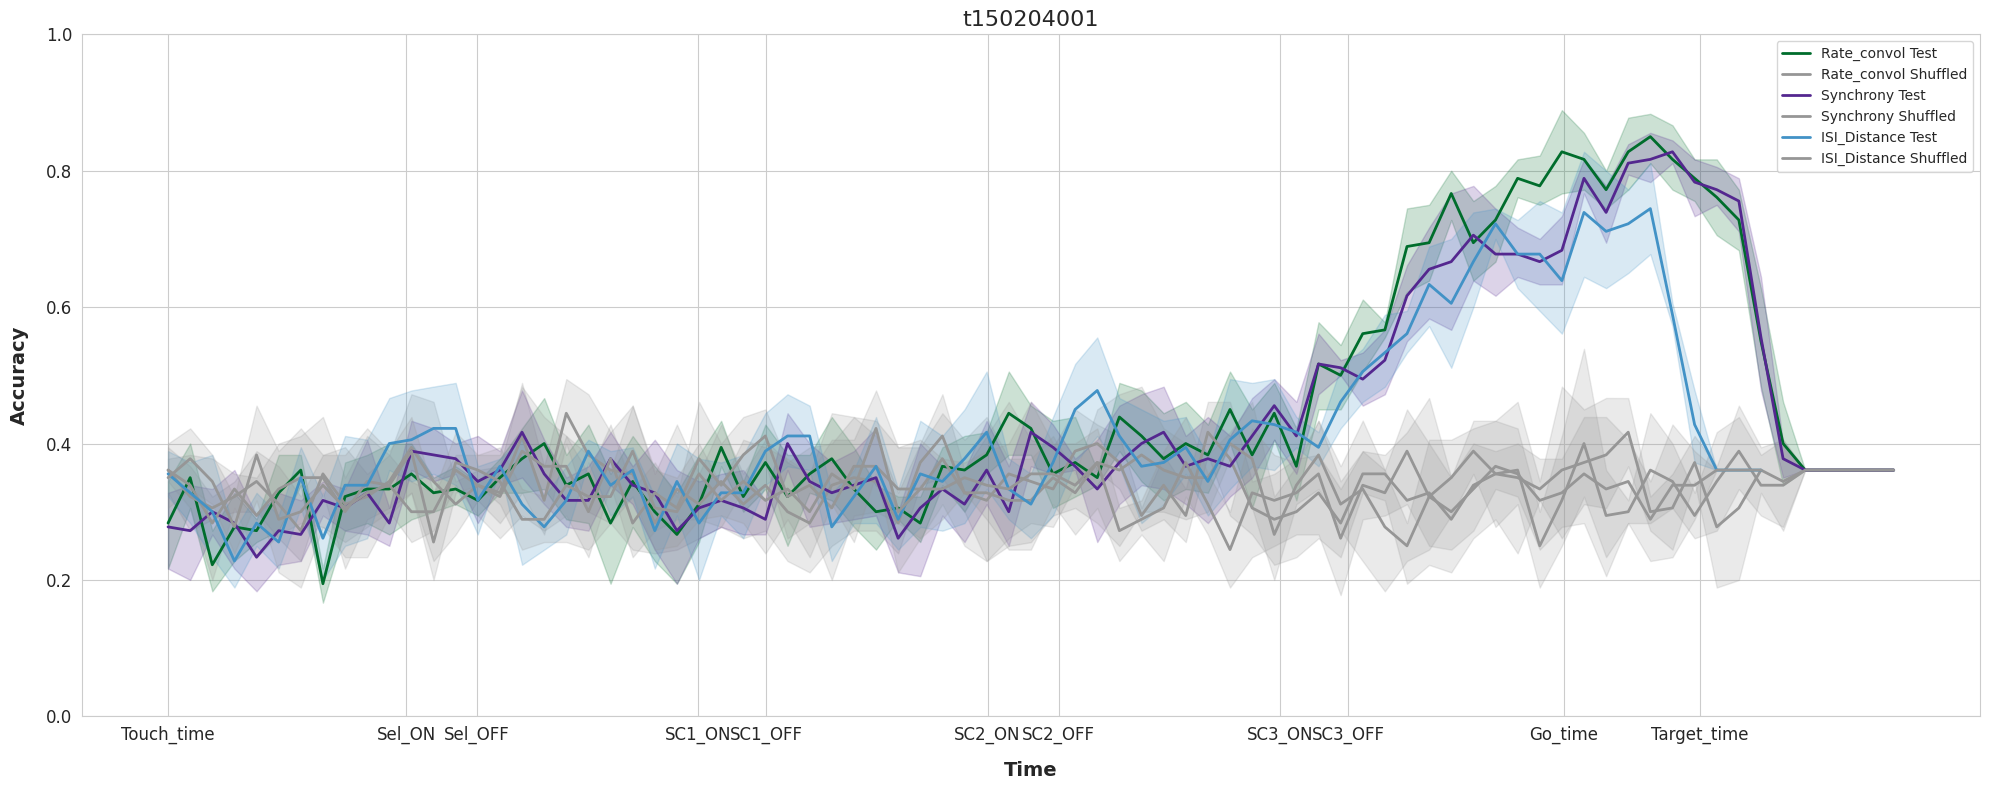

In [11]:
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12 

target_list = ['trial_type']

palette = ['#006d2c', '#54278f', '#4292c6']

color_shuff = '#969696'

### Plot Firing rate ### 

fig, ax = plt.subplots(figsize=(20, 8), dpi=100)  

for i, measure in enumerate(measures_list):

    accuracy_plot = data_list[i]
    
    accuracy_plot_test = accuracy_plot[accuracy_plot["data_type"] == 'test']
    sns.lineplot(accuracy_plot_test, x='time', y='accuracy', color=palette[i], linewidth=2., ax=ax, label=f'{measure} Test')


    accuracy_plot_shuff = accuracy_plot[accuracy_plot["data_type"] == 'shuff']
    sns.lineplot(accuracy_plot_shuff, x='time', y='accuracy', color=color_shuff, linewidth=2., ax=ax, label=f'{measure} Shuffled')

ax.set_xticks(event_vector)
ax.set_xticklabels(event_labels)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xlabel('Time')
ax.set_ylabel('Accuracy')
plt.title(f'{session}', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig(f'/home/INT/mifsud.l/Bureau/presentation/LaminarClub/HistGrad_{session}_position.png')
plt.show()


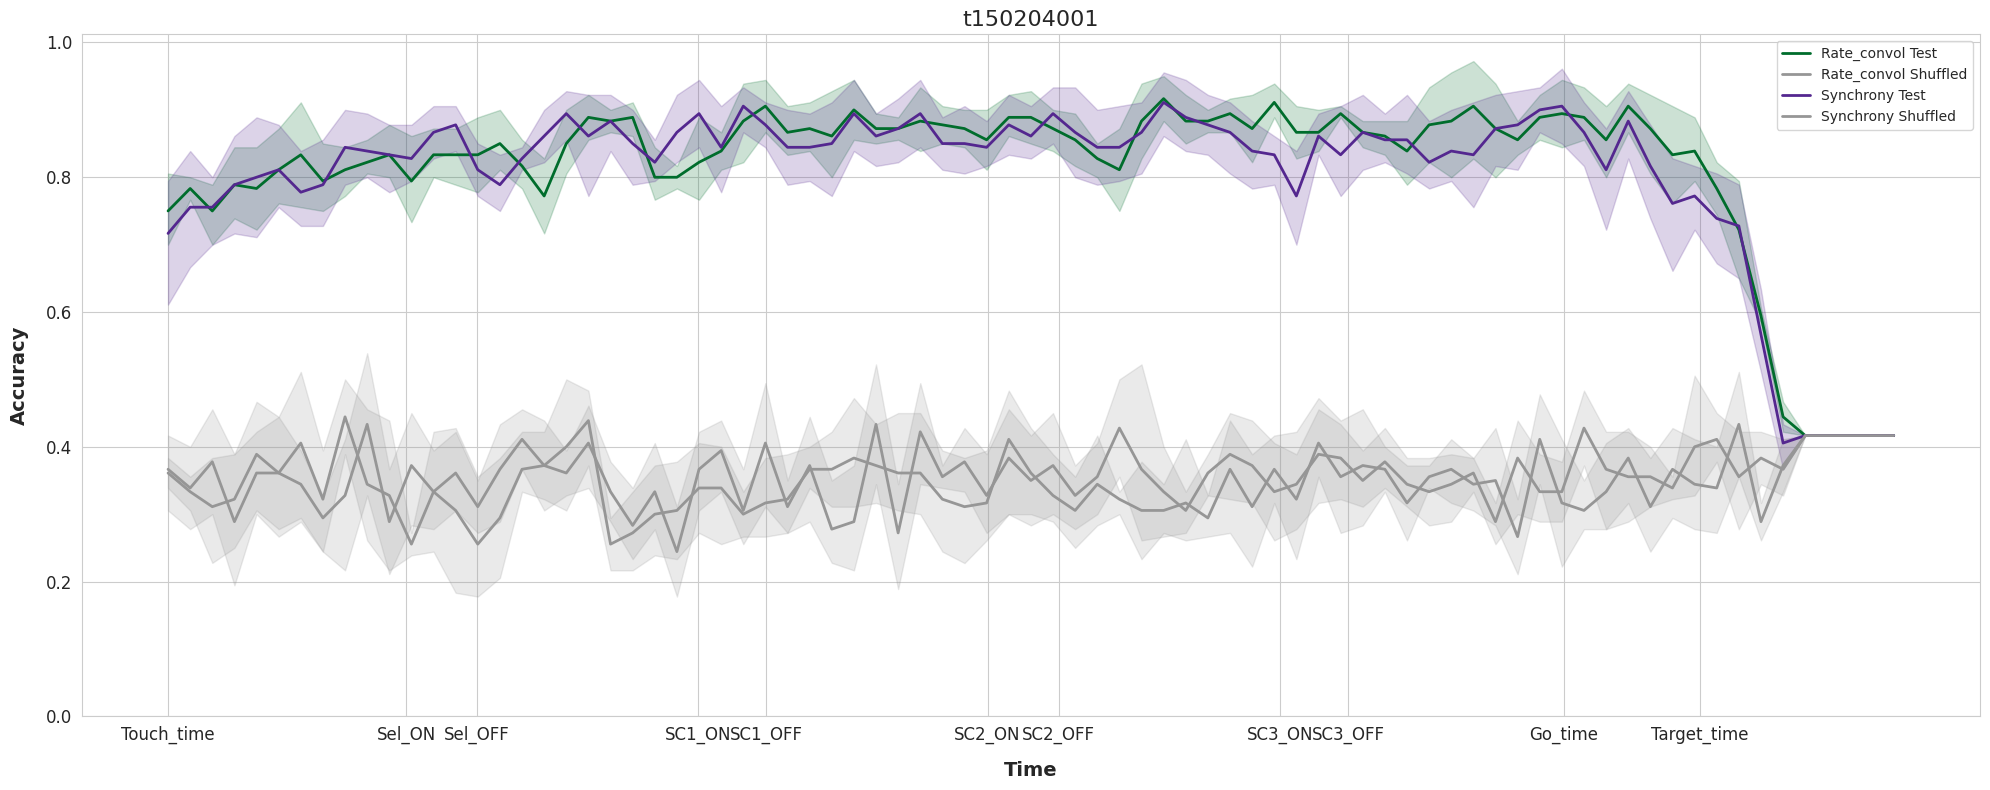

In [22]:
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12 

target_list = ['trial_type']

palette = ['#006d2c', '#54278f']
measures_list = ['Rate_convol', 'Synchrony']

color_shuff = '#969696'

### Plot Firing rate ### 

fig, ax = plt.subplots(figsize=(20, 8), dpi=100)  

for i, measure in enumerate(measures_list):

    accuracy_plot = data_list[i]
    
    accuracy_plot_test = accuracy_plot[accuracy_plot["data_type"] == 'test']
    sns.lineplot(accuracy_plot_test, x='time', y='accuracy', color=palette[i], linewidth=2., ax=ax, label=f'{measure} Test')


    accuracy_plot_shuff = accuracy_plot[accuracy_plot["data_type"] == 'shuff']
    sns.lineplot(accuracy_plot_shuff, x='time', y='accuracy', color=color_shuff, linewidth=2., ax=ax, label=f'{measure} Shuffled')

ax.set_xticks(event_vector)
ax.set_xticklabels(event_labels)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xlabel('Time')
ax.set_ylabel('Accuracy')
plt.title(f'{session}', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig(f'/home/INT/mifsud.l/Bureau/presentation/LaminarClub/HistGrad_{session}_without_ISI.png')
plt.show()